# Initializatoin

Payam Taebi
400104867

## Imports

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.nn import Parameter

from name_dataset import Dataset

# RNN

## Traditional RNN

In the introductory section, we delve into the architecture of Recurrent Neural Networks (RNNs) and elucidate their training methodologies. To gain a deeper understanding of RNNs, you're encouraged to explore further [HERE](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-network)

For the task at hand, you've been furnished with the Names dataset, a compilation comprising thousands of surnames from 18 distinct languages of origin. Your objective is to prognosticate the language of origin for a given name, relying solely on its orthography. Your task primarily involves implementing the section demarcated by `#your_code`.

In [2]:
dataset = Dataset()
for i in range(10):
    category, line, _, _ = dataset.randomTrainingExample()
    print('category =', category, '- random name =', line)

Error occurred while downloading data.zip: --2024-04-29 15:17:19--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.3.37, 18.65.3.71, 18.65.3.38, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.3.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

     0K .......... .......... .......... .......... ..........  1% 6.01M 0s
    50K .......... .......... .......... .......... ..........  3% 7.45M 0s
   100K .......... .......... .......... .......... ..........  5% 18.3M 0s
   150K .......... .......... .......... .......... ..........  7% 19.3M 0s
   200K .......... .......... .......... .......... ..........  8% 17.3M 0s
   250K .......... .......... .......... .......... .......... 10% 22.6M 0s
   300K .......... .......... .......... .......... .......... 12% 32.7M 0s
   350K .......... .......... .......... .......... .....

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.i2h(combined))
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = dataset.n_letters
n_categories = dataset.n_categories
#print(n_letters,n_categories) # 57 18
rnn = RNN(n_letters, n_hidden, n_categories)

In [4]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005

def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(name_tensor.size(0)):
      output, hidden = rnn(name_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    loss.backward()

    # Update parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


And here you can train your model and see it's performance after each 5000 iterations

25000 5% 3.0940 Mata is predicted as a "Japanese" name, status = ✗ (Portuguese)
50000 10% 0.7564 Shen is predicted as a "Chinese" name, status = ✓
75000 15% 0.0271 Brisimitzakis is predicted as a "Greek" name, status = ✓
100000 20% 0.5146 Fearghal is predicted as a "Irish" name, status = ✓
125000 25% 0.6337 Ryu is predicted as a "Korean" name, status = ✓
150000 30% 1.2407 Metz is predicted as a "German" name, status = ✓
175000 35% 1.2640 Hierro is predicted as a "Spanish" name, status = ✓
200000 40% 0.0923 Poplawski is predicted as a "Polish" name, status = ✓
225000 45% 0.0380 Kwak is predicted as a "Korean" name, status = ✓
250000 50% 0.0133 Kwong is predicted as a "Chinese" name, status = ✓
275000 55% 0.5296 Lebeau is predicted as a "French" name, status = ✓
300000 60% 1.5895 Simon is predicted as a "Dutch" name, status = ✗ (French)
325000 65% 0.0081 Gniewek is predicted as a "Polish" name, status = ✓
350000 70% 0.0120 Solomon is predicted as a "French" name, status = ✓
375000 75% 0.

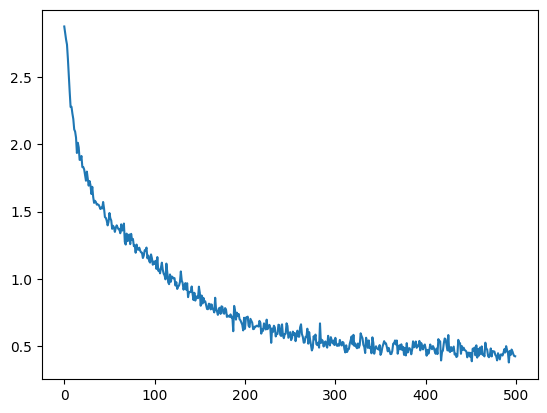

In [5]:
n_iters = 500000
print_every = 25000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.randomTrainingExample()
    #print(category_tensor.shape)
    #print(line_tensor.shape)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, _ = dataset.categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s is predicted as a "%s" name, status = %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    if iter % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

## Traditional RNN Disadvantages

In this part, we aim to delve into the limitations of traditional RNNs:
1.   Recurrent computation is slow
2.   They have difficulty accessing information from many steps back.

You are provided with a simple code that helps you to give the idea better. By modifying this code, you are able to demonstrate the mentioned disadvantages, but you are also free to change the code if needed or use any dataset you want.

**Question:** Do you think using GPU instead of CPU completely solves the first problem?

No, using a GPU instead of a CPU does not completely solve the problem of slow recurrent computation in RNNs. While GPUs are highly efficient at parallel computation and can speed up certain operations, RNNs inherently involve sequential dependencies. This means that each timestep in the sequence must be processed sequentially, which limits the degree to which RNN computations can be parallelized.

While GPUs can accelerate certain aspects of RNN training and inference, they cannot completely overcome the sequential nature of RNN computations. Factors such as the size of the network, the complexity of the computation, and the efficiency of the implementation also play significant roles in determining the overall speed and performance of RNNs.


Note: The main goal of this part is to help you understand these problems better. Don't be too hard to implement and delivery.

Epoch [10/100], Loss: 1.3337
Epoch [20/100], Loss: 1.2591
Epoch [30/100], Loss: 1.1824
Epoch [40/100], Loss: 1.0971
Epoch [50/100], Loss: 0.9962
Epoch [60/100], Loss: 0.8731
Epoch [70/100], Loss: 0.7244
Epoch [80/100], Loss: 0.5555
Epoch [90/100], Loss: 0.3867
Epoch [100/100], Loss: 0.2459


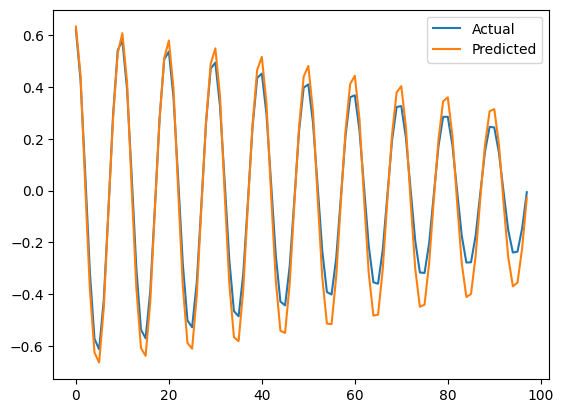

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate sinusoidal temperature data with decreasing range over time
np.random.seed(0)
num_periods = 50
timesteps_per_period = 10
total_timesteps = num_periods * timesteps_per_period

# Generate decreasing factor
decreasing_factor = np.linspace(1, 0.1, total_timesteps)

# Generate temperature data with decreasing sinusoidal range
temperature_data = np.sin(np.linspace(0, 2*np.pi*num_periods, total_timesteps)) * decreasing_factor

# Normalize the data
temperature_data = (temperature_data - np.mean(temperature_data)) / np.std(temperature_data)

# Convert numpy array to PyTorch tensor
temperature_data = torch.tensor(temperature_data, dtype=torch.float32).view(-1, 1)

# Define function to create dataset with sinusoidal pattern
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        seq_in = data[i:i+seq_length]
        seq_out = data[i+seq_length]
        X.append(seq_in)
        Y.append(seq_out)
    return torch.stack(X), torch.stack(Y)

# Define sequence length and create dataset
sequence_length = 10  # Number of previous days to look at for prediction
X, Y = create_dataset(temperature_data, sequence_length)

# Split the dataset into train and test sets
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = 1
hidden_size = 10
output_size = 1

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Plot actual vs predicted
plt.plot(Y_test.numpy(), label='Actual')
plt.plot(test_predictions.numpy(), label='Predicted')
plt.legend()
plt.show()

# LSTM Preparation

Now that you have experience with traditional RNNs, it's time to implement the LSTM model. Your goal is to implement the cell and model for LSTM architecture. The proposed dataset for this section is MNIST, allowing you to focus solely on model implementation.

In [7]:
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor())

batch_size = 128
n_iters = 6000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 18033586.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 411060.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4499987.57it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 4252350.17it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## LSTM Cells

In [9]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / torch.sqrt(torch.tensor(self.hidden_size, dtype=torch.float))
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size)
            hx = (hx, hx)

        hx, cx = hx

        gates = self.xh(input) + self.hh(hx)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_gate = torch.tanh(cell_gate)
        output_gate = torch.sigmoid(output_gate)

        cy = forget_gate * cx + input_gate * cell_gate
        hy = output_gate * torch.tanh(cy)

        return hy, cy


## LSTM Models

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = LSTMCell(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        h0 = torch.zeros(x.size(0), self.hidden_dim)
        c0 = torch.zeros(x.size(0), self.hidden_dim)

        # Initialize
        hn = h0
        cn = c0

        outs = []

        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))
            outs.append(hn.unsqueeze(1))

        out = torch.cat(outs, dim=1)


        out = self.fc(out[:, -1, :])

        return out


In [11]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY 1 OR 2
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)


learning_rate = 0.01

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
num_epochs = 5
print_interval = 500

running_loss = 0.0
total = 0
correct = 0

q = 0
for epoch in range(num_epochs):
    model.train()

    for i, (images, labels) in enumerate(train_loader, 0):
        q+=1
        optimizer.zero_grad()
        images = images.view(-1, 28, 28)  # Reshape to (batch_size, 28, 28)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if (q+1) % print_interval == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{i+1}/{len(train_loader)}], Loss: {running_loss/print_interval:.4f}, Accuracy: {(correct/total)*100:.2f}%')
            running_loss = 0.0

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28, 28)  # Reshape to (batch_size, 28, 28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on Test Dataset after Epoch {epoch+1}: {(correct/total)*100:.2f}%')


Accuracy on Test Dataset after Epoch 1: 95.88%
Epoch [2/5], Iteration [30/469], Loss: 0.3672, Accuracy: 95.98%
Accuracy on Test Dataset after Epoch 2: 97.52%
Epoch [3/5], Iteration [61/469], Loss: 0.0962, Accuracy: 97.74%
Accuracy on Test Dataset after Epoch 3: 98.23%
Epoch [4/5], Iteration [92/469], Loss: 0.0706, Accuracy: 98.53%
Accuracy on Test Dataset after Epoch 4: 98.45%
Epoch [5/5], Iteration [123/469], Loss: 0.0576, Accuracy: 98.49%
Accuracy on Test Dataset after Epoch 5: 98.03%


# Sentiment Analysis

Now you are ready to face a real-world problem. In this task, we want you to do a sentiment analysis on the [IMDB dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). The main goal is to reach more than an acceptable accuracy of **75%** on LSTM model. You are free to use torch.nn.LSTM to design your architecture, but you must prepare the IMDB dataset on your own.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from collections import Counter
from torchsummary import summary

In [14]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: IMDB Dataset.csv        


In [15]:
df = pd.read_csv('IMDB Dataset.csv')

In [16]:
def preprocess_text(text):
    clean_text = re.compile('<.*?>')
    text = re.sub(clean_text, '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    return text

df['review'] = df['review'].apply(preprocess_text)

# Tokenize
all_words = ' '.join(df['review']).split()
word_counts = Counter(all_words)
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

word_to_idx = {word: i + 1 for i, (word, _) in enumerate(sorted_word_counts)}

#  text 2 sequences
X = []
for review in df['review']:
    seq = [word_to_idx[word] for word in review.split() if word in word_to_idx]
    X.append(seq)

# Padding
max_seq_len = 200
X_padded = [seq[:max_seq_len] + [0]*(max_seq_len - len(seq)) if len(seq) < max_seq_len else seq[:max_seq_len] for seq in X]

y = df['sentiment'].map({'positive': 1, 'negative': 0}).values


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [19]:
input_size = len(word_to_idx) + 1  # Vocabulary size (+1 for padding token)
embedding_dim = 128
hidden_size = 128
num_layers = 2
output_size = 1

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, embedding_dim, hidden_size, num_layers, output_size).cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


Epoch [1/5], Loss: 0.6928
Epoch [2/5], Loss: 0.6908
Epoch [3/5], Loss: 0.6689
Epoch [4/5], Loss: 0.4735
Epoch [5/5], Loss: 0.3283


In [21]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Convert probabilities to binary predictions
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 83.07%
